In [1]:
import numpy as np
import torch
import jax
import jax.numpy as jnp
from jax import jit, random, vmap, pmap
from functools import wraps, partial

import matplotlib.pyplot as plt

In [2]:
plt.rc("figure", dpi=250, titlesize=8)
plt.rc("legend", fontsize=6)

In [3]:
def slow_find_closest(x: np.array, ys: np.array) -> np.array:
    """ Find the closest y to x """
    residuals = x[None] - ys
    norms = np.linalg.norm(residuals, axis=-1)
    
    i = np.argmin(norms, axis=0)
    
    return ys[i], norms[i]

In [4]:
def slow_find_n_closest(x: np.array, ys: np.array, n: int) -> np.array:
    """ Find the closest y to x """
    residuals = x[None] - ys
    norms = np.linalg.norm(residuals, axis=-1)
    
    i = np.argpartition(norms, n-1, axis=0)[:n]
    
    return np.mean(ys[i], axis=0), np.mean(norms[i], axis=0)

In [5]:
def slow_fuzzy_match(xs: np.array, ys: np.array, n: int = 1) -> (np.array, np.array):
    """ Find means and standard deviations for a fuzzy matching of y in x """
    xs = xs.reshape(-1, xs.shape[-1])
    ys = ys.reshape(-1, ys.shape[-1])
    means = np.empty_like(xs)
    stds = np.empty(xs.shape[0])
    for i, y in enumerate(ys):
        mean, std = slow_find_n_closest(y, xs, n)
        means[i] = mean
        stds[i] = std
    
    return means, stds

In [6]:
def find_closest(x: jnp.array, ys: jnp.array) -> (jnp.array, jnp.array):
    """ Find the closest y to x """
    residuals = x[None] - ys
    norms = jnp.linalg.norm(residuals, axis=-1)
    
    i = jnp.argmin(norms, axis=0)
    
    return ys[i], norms[i]

find_closest = jit(vmap(find_closest, in_axes=(0, None)))

In [7]:
def fuzzy_match(xs: np.array, ys: np.array, batch_size: int = None) -> (np.array, np.array):
    """ Find means and standard deviations for a fuzzy matching of y in x """
    xs = xs.reshape(-1, xs.shape[-1])
    ys = ys.reshape(-1, ys.shape[-1])
    
    if batch_size is None:
        means, stds = find_closest(ys, xs)
    else:
        means = []
        stds = []
        for start in range(0, len(ys), batch_size):
            y_batch = ys[start:start + batch_size]
            mean_batch, std_batch = find_closest(y_batch, xs)
            means.append(mean_batch)
            stds.append(std_batch)
        
        means = np.concatenate(means, axis=0)
        stds = np.concatenate(stds, axis=0)
            
    return np.asarray(means), np.asarray(stds)

In [8]:
def time(expr, n, dim=3, repeat=10, number=1):
    print(n)
    import timeit
    x = np.random.standard_normal((n, dim))
    y = np.random.standard_normal((n, dim))
    
    times = timeit.repeat(expr, repeat=repeat, number=number, globals=globals() | locals())
    
    return times

In [9]:
# ns = np.logspace(np.log10(500), np.log10(5e4), 10, base=10, dtype=int)
# print(ns)
# labels = ["batched", "jit"]

# times = np.array([
#     [time("fuzzy_match(x, y, batch_size=16384)", n, number=10, repeat=10) for n in ns],
#     [time("jit_fuzzy_match(x, y, batch_size=16384)", n, number=10, repeat=10) for n in ns],
# ])

# # remove compile time
# times = times[:, :, 1:]

# for i, (t, label) in enumerate(zip(times, labels)):
#     means, stds = t.mean(axis=-1), t.std(axis=-1)
#     plt.plot(ns, means, label=label, color=f"C{i}")
#     plt.fill_between(ns, means - stds, means + stds, color=f"C{i}", alpha=0.25)

# plt.legend()

In [11]:
x = np.random.standard_normal((2 ** 11, 2))
y = np.random.standard_normal((2 ** 11, 2)) + np.array([3,0])

x.shape, y.shape

((2048, 2), (2048, 2))

In [12]:
means, stds = fuzzy_match(x, y)

In [20]:
means, stds = slow_fuzzy_match(x, y, n=7)

In [21]:
means[0:5, 0], stds[0:5]

(array([2.4907837 , 2.14779494, 2.39298792, 2.63641493, 2.5706451 ]),
 array([0.60118872, 0.21591544, 0.36914624, 2.24696418, 0.7005059 ]))

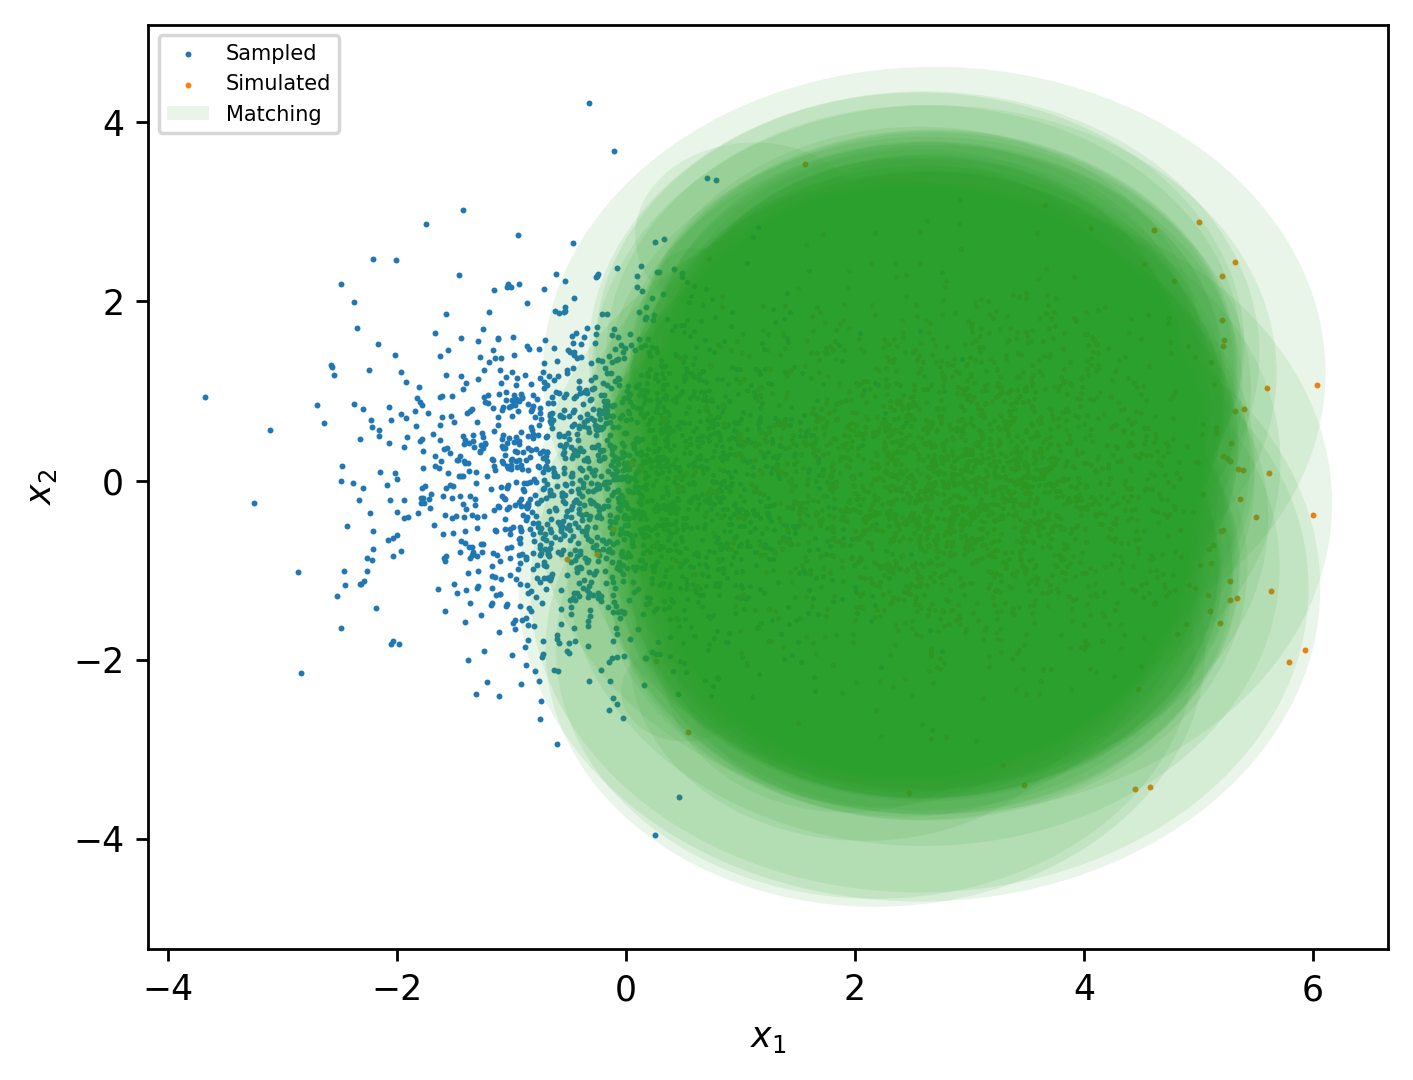

In [22]:
plt.scatter(x[:, 0], x[:, 1], s=0.5, label="Sampled")
plt.scatter(y[:, 0], y[:, 1], s=0.5, label="Simulated")
ax = plt.gca()
for i, (mean, std) in enumerate(zip(means, stds)):
    if i == 0:
        label = "Matching"
    else:
        label = None
    circle = plt.Circle(xy=mean, radius=std, color="C2", alpha=0.1, lw=0, label=label)
    ax.add_patch(circle)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.savefig("fuzzy_matching.png")

In [23]:
for i in range(1000):
    y_r2 = np.random.normal(means, stds.reshape(-1, 1))
    means, stds = slow_fuzzy_match(x, y_r2, n=3)

[ 2.92817776 -1.17948029] [ 0.35636236 -0.5546047 ]
[ 2.92817776 -1.17948029] [ 0.35636236 -0.5546047 ]


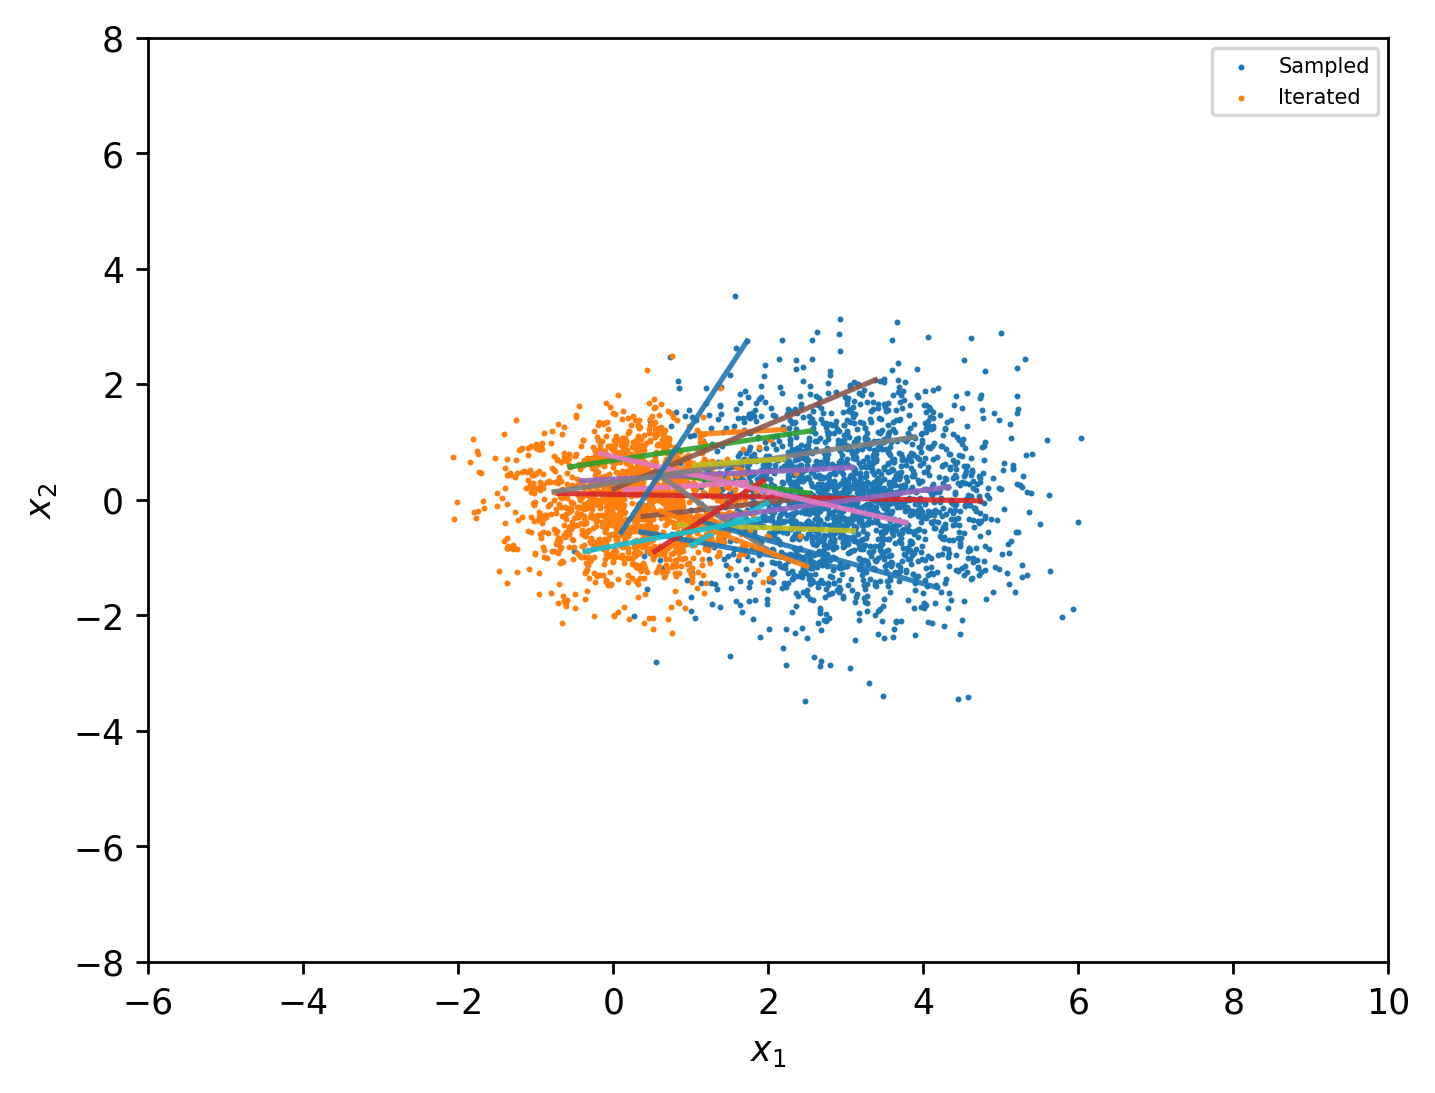

In [48]:
plt.scatter(y[:, 0], y[:, 1], s=0.5, label="Sampled")
plt.scatter(y_r2[:, 0], y_r2[:, 1], s=0.5, label="Iterated")
ax = plt.gca()
print(y[0], y_r2[0])
for i in range(y.shape[0]):
    if i == 0:
        label = "Matching"
        print(y[i], y_r2[i])
    else:
        label = None
    plt.plot([y[i,0],y_r2[i,0]], [y[i,1],y_r2[i, 1]], alpha=0.9)
    if i == 20:
        break

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.xlim(-6, 10)
plt.ylim(-8,8)
plt.savefig("fuzzy_matching_4.png")

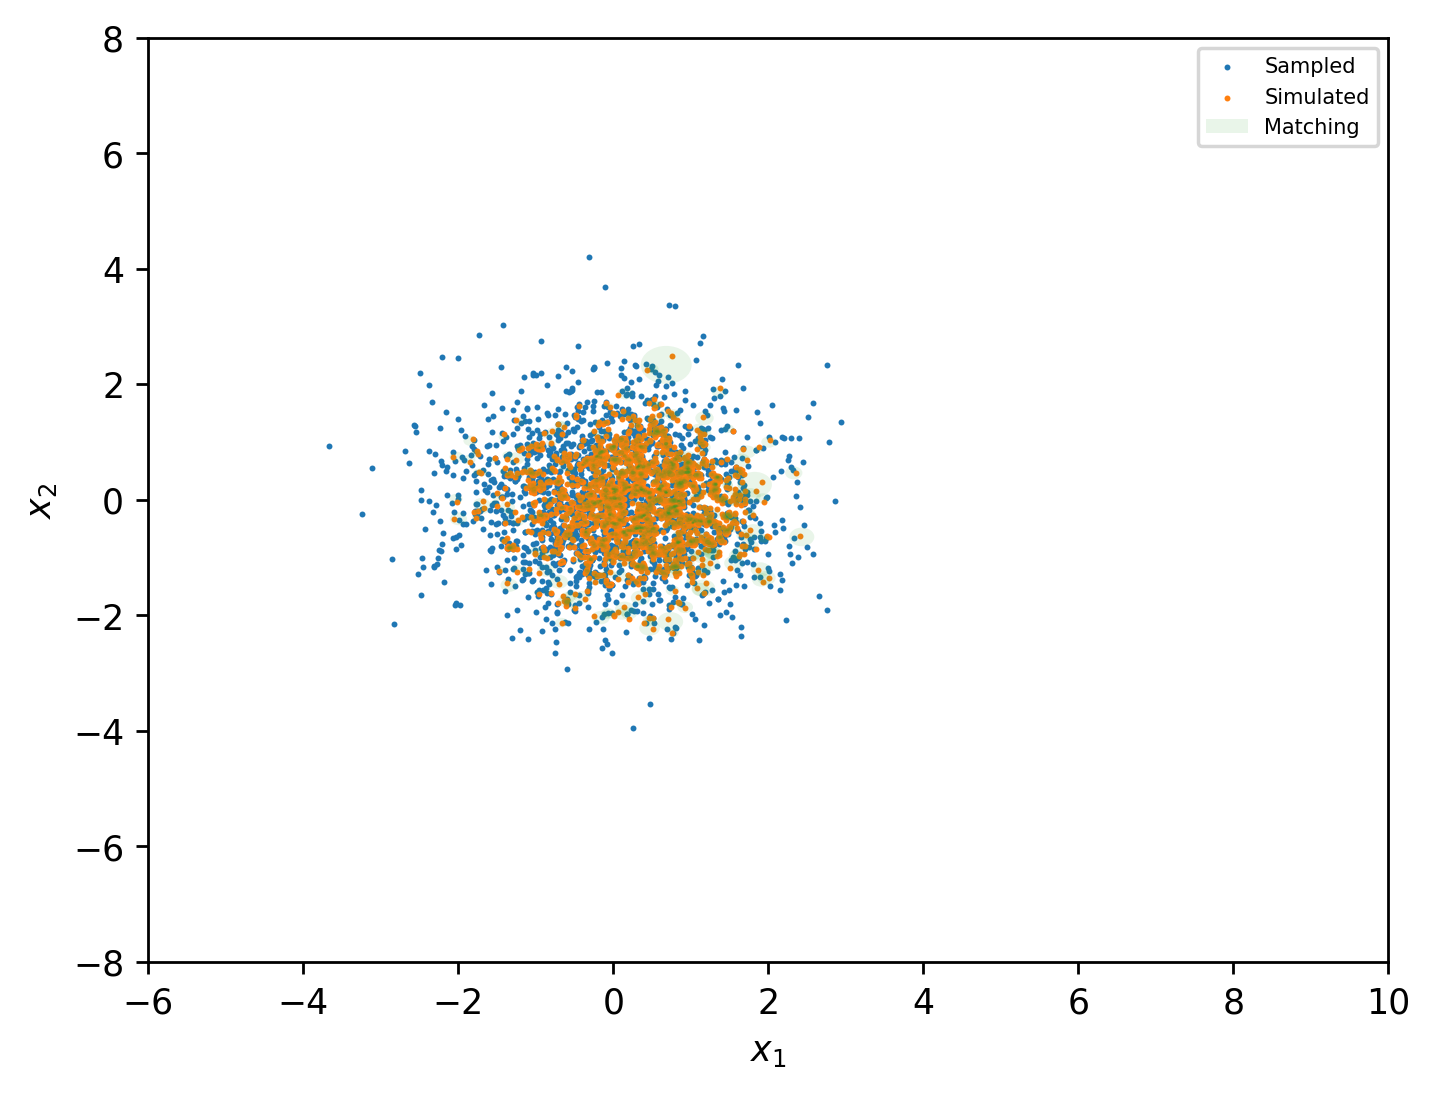

In [24]:
plt.scatter(x[:, 0], x[:, 1], s=0.5, label="Sampled")
plt.scatter(y_r2[:, 0], y_r2[:, 1], s=0.5, label="Simulated")
ax = plt.gca()
for i, (mean, std) in enumerate(zip(means, stds)):
    if i == 0:
        label = "Matching"
    else:
        label = None
    circle = plt.Circle(xy=mean, radius=std, color="C2", alpha=0.1, lw=0, label=label)
    ax.add_patch(circle)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.xlim(-6, 10)
plt.ylim(-8,8)
plt.savefig("fuzzy_matching_4.png")

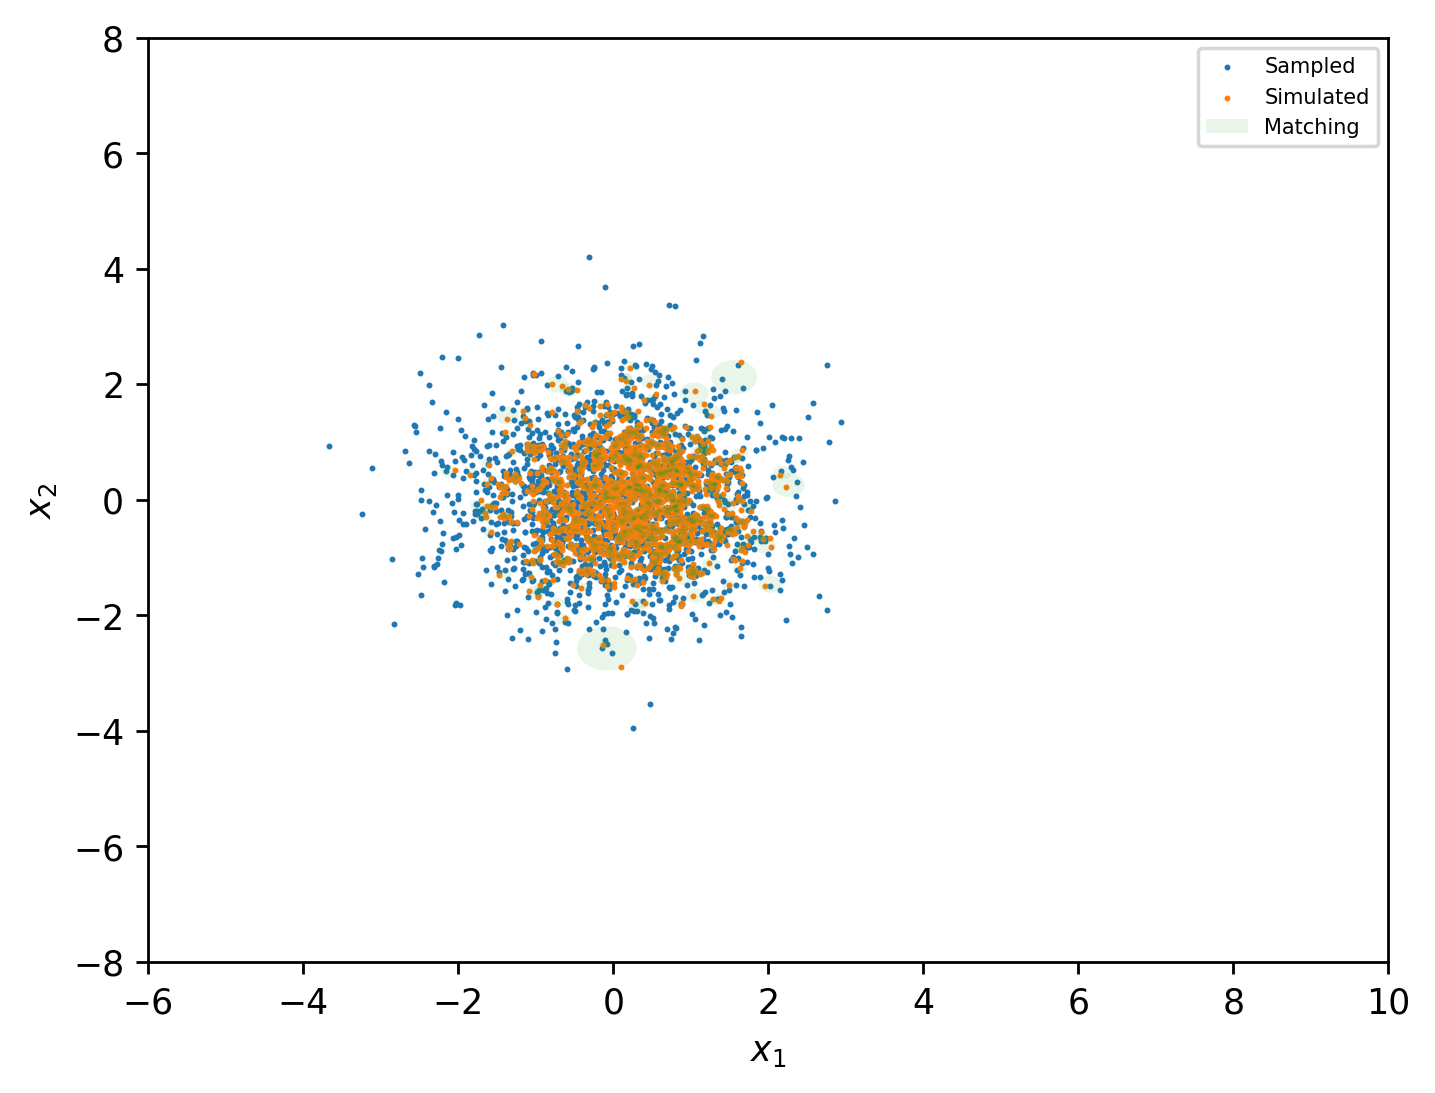

In [19]:
plt.scatter(x[:, 0], x[:, 1], s=0.5, label="Sampled")
plt.scatter(y_r2[:, 0], y_r2[:, 1], s=0.5, label="Simulated")
ax = plt.gca()
for i, (mean, std) in enumerate(zip(means, stds)):
    if i == 0:
        label = "Matching"
    else:
        label = None
    circle = plt.Circle(xy=mean, radius=std, color="C2", alpha=0.1, lw=0, label=label)
    ax.add_patch(circle)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.xlim(-6, 10)
plt.ylim(-8,8)
plt.savefig("fuzzy_matching_4.png")

In [ ]:
%timeit slow_fuzzy_match(x, y)

In [ ]:
%timeit fuzzy_match(x, y)

In [ ]:
b = np.random.standard_normal((10,2))
b = b[None]
print(b)